<a href="https://colab.research.google.com/github/furio1999/Natural-Language-Processing/blob/main/Word_Embeddings_and_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Copyright 2021 Sapienza NLP research group (http://nlp.uniroma1.it/)**

Authors: Edoardo Barba, Michele Bevilacqua, Cesare Campagnano, Simone Conia, ‪Pere-Lluís Huguet Cabot‬, Luigi Procopio, Roberto Navigli

All the material is made available under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 License (international): https://creativecommons.org/licenses/by-nc-sa/4.0/.

# Introduction

In this notebook we are going to discuss two of the most used techniques in Natural Language Processing:
1. **Word Embeddings**: we will show the benefits of leveraging pretrained Word Embeddings on our running example i.e. the "Amazon Reviews Stars Predictors".
2. **Recurrent Neural Networks**: a neural architecture that is meant for modeling sequences of elements (e.g. words in text).

At the end of this notebook you will understand why these two techniques combined have been a major breakthrough in Natural Language Processing and you will be able to apply them on different tasks. 

Let the dances begin.


## Prepairing the Environment


As usual, we will start by prepairing the environment and downloading the Amazon Reviews dataset.

In [ ]:
! pip install pytorch-lightning

In [ ]:
# general
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from typing import *

# torch
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

# Lightning
import pytorch_lightning as pl

In [ ]:
# sample_data: we don't need this folder
! rm -rf sample_data

# let's create a new folder and download the dataset. We'll also need to unzip it
! mkdir data
! wget -O data/amazon-reviews.tsv.gz https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz
! gzip -d data/amazon-reviews.tsv.gz

mkdir: cannot create directory ‘data’: File exists
--2021-04-08 11:19:01--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.26.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.26.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475199894 (453M) [application/x-gzip]
Saving to: ‘data/amazon-reviews.tsv.gz’

data/amazon-reviews 100%[===================>] 453.19M  35.9MB/s    in 14s     

2021-04-08 11:19:16 (32.5 MB/s) - ‘data/amazon-reviews.tsv.gz’ saved [475199894/475199894]

gzip: data/amazon-reviews.tsv already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
! tail +2 data/amazon-reviews.tsv | cut -f8,14 > data/dataset.raw.tsv 

In [ ]:
! head -5 data/dataset.raw.tsv

5	Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.
5	Loved it,  I didn't even realise it was a gaming mouse,  I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.
1	poor quality work and not as it is advertised.
3	nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.
4	Great amiibo, great for collecting. Quality material to be desired, since its not perfect.


## Word Embeddings

Now we give a brief overview of some of the main advantages they provide over handcrafted features:

1. **Pretrained syntactic- and semantic-level features**.
2. **Task agnostic representation** that can be utilized in several applications.
3. Handling of synonyms and more in general related words via **neighbors-aware representations**.

To understand the capabilities of the Word Embeddings, we will plug them in our running example: the Amazon Reviews Stars Predictor. 
Indeed, we will replace the usage of hand-crafted features (e.g. the presence or the absence of specific words) to represent each review, by utilizing the embedding of the words in it. To keep things simple we will start by using the **average of those vectors**.

First of all, let's retrieve the word embeddings we are going to use for the rest of the notebook. While, theoretically, we could train our own word embeddings with the technique we introduced in the Notebook 2b, a number of more-sophisticated techniques have been developed to create better vectorial representations.

In this notebook, we will use [FastText](https://fasttext.cc/docs/en/crawl-vectors.html), one of the currently most popular word embeddings. So let's download them and get our hands dirty.

In [ ]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
! mv cc.en.300.vec.gz data/.
! gzip -d data/cc.en.300.vec.gz

--2021-04-08 11:20:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  12.3MB/s    in 1m 46s  

2021-04-08 11:22:26 (11.9 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

gzip: data/cc.en.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
! head data/cc.en.300.vec

2000000 300
, 0.1250 -0.1079 0.0245 -0.2529 0.1057 -0.0184 0.1177 -0.0701 -0.0401 -0.0080 0.0772 -0.0226 0.0893 -0.0487 -0.0897 -0.0835 0.0200 0.0273 -0.0194 0.0964 0.0875 0.0098 0.0453 0.0155 0.1462 0.0225 0.0448 0.0137 0.0570 0.1764 -0.1072 -0.0826 0.0173 0.1090 0.0207 -0.1271 0.2445 0.0375 -0.0209 -0.0445 0.0540 0.1282 0.0437 0.0588 0.0984 0.0539 0.0004 0.1290 0.0242 -0.0120 -0.0480 0.0346 -0.0664 -0.0330 -0.0625 -0.0708 -0.0579 0.1738 0.4448 0.0370 -0.1001 -0.0032 0.0359 -0.0685 -0.0361 0.0070 0.1316 -0.0945 -0.0610 0.0178 -0.0763 -0.0192 0.0033 0.0056 0.1878 -0.0754 -0.0095 0.0446 -0.0588 0.0244 -0.0251 -0.0493 0.0308 -0.0359 -0.1884 -0.0988 0.1887 0.0459 -0.0816 -0.1524 -0.0375 -0.0692 0.0427 -0.0471 -0.0086 -0.2190 -0.0064 0.0877 -0.0074 -0.1400 -0.0156 0.0161 0.1040 -0.1445 -0.0719 -0.0144 -0.0293 -0.0126 0.0619 -0.0373 -0.1471 -0.2552 -0.0685 0.2892 -0.0275 0.0436 0.0311 0.0249 0.0142 0.0403 0.1729 0.0023 -0.0255 -0.0212 0.0701 -0.0727 0.0279 0.1151 -0.0394 -0.0962 -0.0598 -0.

The general concept behind word embeddings is the same regardless of the considered technique behind their creation: providing a feature-rich vectorial representation of each word. We will now go back to our task but why don't you explore the space of these FastText embeddings yourself?

So, time to define our training, validation and test sets. In the previous notebooks, we used a hand-crafted function $\phi$ to induce these sets, which is obviously not very *real-world* for at least $2$ reasons:
* the vast majority of reviews cannot be really classified (synonyms, uncovered words, ...).
* the logical (and **correct**) flow is that $i)$ you receive data and, then, $ii)$ you define feature functions that can fit them, not the other way around (in Notebook 2, we did it for pedagogical reasons, but bear in mind that it is **not** the correct approach).

Thus, first of all, let's correct our setting: we will consider **all** (well, not really all of them, we will limit them for computational and timing purposes) available reviews in the downloaded dataset and stop the filtering procedure on function $\phi$. Then, we will directly split them into train, dev and test as usual.

In [ ]:
! head -10 data/dataset.raw.tsv

5	Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.
5	Loved it,  I didn't even realise it was a gaming mouse,  I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.
1	poor quality work and not as it is advertised.
3	nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.
4	Great amiibo, great for collecting. Quality material to be desired, since its not perfect.
1	The remote constantly have to be adjusted in order to charge.
5	I have a 2012-2013 XL and this is very durable, comfortable, and really cool looking.
5	Perfect, kids loved them. Great protection for their technology.
5	Excelent
4	Slippery but expected


- Training set: 50k reviews
- Validation set: 5k reviews
- Test set: 5k reviews

In [ ]:
! shuf data/dataset.raw.tsv | head -60000 > data/dataset.shuf.tsv
! head -5000 data/dataset.shuf.tsv > data/dataset.test.tsv
! head -10000 data/dataset.shuf.tsv | tail -5000 > data/dataset.validation.tsv
! tail +10001 data/dataset.shuf.tsv > data/dataset.train.tsv

Ok, but now that we removed the *induction tecnique* that made the definition of $\phi$ simple, how do we define $\phi$?

As it turns out, this is one of the main applications of word embeddings. NLP systems commonly leverage functions $\phi$-s that essentially revolve to some manipulation of the original word embeddings of each word in the provided input text.

So, let's first load the actual word embeddings. Due to memory constraints we are going to limit the number of words in our vocabulary to 100K.

In [ ]:
word_vectors = dict()
words_limit = 100_000
with open('data/cc.en.300.vec') as f:

    next(f)  # skip header

    for i, line in tqdm(enumerate(f), total=words_limit):

        if i == words_limit:
            break

        word, *vector = line.strip().split(' ')
        vector = torch.tensor([float(c) for c in vector])
        
        word_vectors[word] = vector

We recall that most of the word embeddings techniques tend to cluster words that co-occur frequently. We can see that this property holds even for the embeddings that we are currently using (i.e. FastText) by examining the cosine similarity.

In [ ]:
def cosine_similarity(v1: torch.Tensor, v2: torch.Tensor) -> float:
    num = torch.sum(v1 * v2)
    den = torch.linalg.norm(v1) * torch.linalg.norm(v2)
    return (num / den).item()

In [ ]:
cosine_similarity(word_vectors['king'], word_vectors['queen'])

0.7069180607795715

In [ ]:
cosine_similarity(word_vectors['woman'], word_vectors['man'])

0.7658365964889526

In [ ]:
cosine_similarity(word_vectors['plain'], word_vectors['man'])

0.19196707010269165

We can finally define our first word-embedding-powered function $\phi$. This first version will be quite simple: it just converts any review to a vector by **averaging the embeddings corresponding to each word in it**.

In [ ]:
def review2vector(review: str) -> Optional[torch.Tensor]:
    reviews_word_vector = [word_vectors[w] for w in review.split(' ') if w in word_vectors]
    
    if len(reviews_word_vector) == 0:
        return None

    reviews_word_vector = torch.stack(reviews_word_vector)  # tensor shape: (#words X #features)
    return torch.mean(reviews_word_vector, dim=0)

We define i a separate function the way we convert each review into a vector. We opted for this strategy to highlight that **we are using the word embeddings just as another way to encode discrete sequences of words in continuous vectors**, i.e. as a different function $\phi$.

In [ ]:
# same class as Notebook 4
class AmazonReviewsDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, review2vector):
        self.data_store = []
        self.init_structures(dataset_path, review2vector)

    def init_structures(self, dataset_path: str, review2vector) -> None:

        with open(dataset_path) as f:
            
            next(f)  # skip headers

            for line in f:
                
                try:
                    stars, review = line.strip().split('\t')
                except:
                    continue
                
                review_vector = review2vector(review)

                if review_vector is None:
                    continue

                self.data_store.append((review_vector, int(stars) - 1))

    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]


Also the AmazonReviewsDataModule is untouched by our modification.

In [ ]:

class AmazonReviewsDataModule(pl.LightningDataModule):

    def __init__(
        self, 
        data_train_path: str,
        data_dev_path: str,
        data_test_path: str,
        batch_size: int,
        collate_fn=None
    ) -> None:
        super().__init__()
        self.data_train_path = data_train_path
        self.data_dev_path = data_dev_path
        self.data_test_path = data_test_path
        self.batch_size = batch_size
        self.collate_fn = collate_fn

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = AmazonReviewsDataset(self.data_train_path, review2vector)
            self.validation_dataset = AmazonReviewsDataset(self.data_dev_path, review2vector)
        elif stage == 'test':
            self.test_dataset = AmazonReviewsDataset(self.data_test_path, review2vector)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.validation_dataset, batch_size=self.batch_size)

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
amazon_review_dm = AmazonReviewsDataModule(
    data_train_path='data/dataset.train.tsv',
    data_dev_path='data/dataset.validation.tsv',
    data_test_path='data/dataset.test.tsv',
    batch_size=32,
)

Let's check the shape of the batch elements our test dataset returns. If everything is correct, shapes should be ($batch\ size \times features$) for X and ($batch\ size$) for y.

In [ ]:
amazon_review_dm.setup('test')
test_dataloader = amazon_review_dm.test_dataloader()

for batch in test_dataloader:
    X, y = batch
    print(f"batch X shape: {X.shape}")
    print(f"batch y shape: {y.shape}")
    break

batch X shape: torch.Size([32, 300])
batch y shape: torch.Size([32])


Finally, here we use the same AmazonReviewClassifier of Notebook 4 with the only difference being the number of features in input: word embedding size (300) vs hand-crafted features size (10).

In [ ]:

class AmazonReviewClassifier(pl.LightningModule):

    REVIEWS_CLASSES = 5

    def __init__(self, n_features: int, n_hidden: int):
        super().__init__()
        # classification function
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, self.REVIEWS_CLASSES)
        
        # criterion
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        # metrics
        self.val_f1 = pl.metrics.F1(self.REVIEWS_CLASSES)
        self.test_f1 = pl.metrics.F1(self.REVIEWS_CLASSES)
        
        # hyperparams store
        self.save_hyperparameters()


    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # actual forward
        out = self.lin1(x)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)

        # compute logits (which are simply the out variable) and the actual probability distribution (pred, as it is the predicted distribution)
        logits = out
        pred = torch.softmax(logits, dim=-1)

        result = {'logits': logits, 'pred': pred}

        # compute loss
        if y is not None:
            # while mathematically the CrossEntropyLoss takes as input the probability distributions,
            # torch optimizes its computation internally and takes as input the logits instead
            loss = self.loss(logits, y)
            result['loss'] = loss

        return result

    def training_step(
        self, 
        batch: Tuple[torch.Tensor], 
        batch_idx: int
    ) -> torch.Tensor:
        forward_output = self.forward(*batch)
        return forward_output['loss']

    def validation_step(
        self, 
        batch: Tuple[torch.Tensor], 
        batch_idx: int
    ):
        forward_output = self.forward(*batch)
        
        self.val_f1(forward_output['pred'], batch[1])

        self.log('val_f1', self.val_f1, prog_bar=True)
        self.log('val_loss', forward_output['loss'], prog_bar=True)

    def test_step(
        self,
        batch: Tuple[torch.Tensor],
        batch_idx: int
    ):
        forward_output = self.forward(*batch)
        self.test_f1(forward_output['pred'], batch[1])
        self.log('test_f1', self.test_f1, prog_bar=True)

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1, momentum=0.0)
        return optimizer

In [ ]:
amazon_review_classifier = AmazonReviewClassifier(
    n_features=300, 
    n_hidden=128
)

Here we define the PyTorch Lightning trainer

In [ ]:
def get_trainer(ckpt_dir: str) -> pl.Trainer:

    early_stopping = pl.callbacks.EarlyStopping(
        monitor='val_f1',  # the value that will be evaluated to activate the early stopping of the model.
        patience=3,  # the number of consecutive attempts that the model has to raise (or lower depending on the metric used) to raise the "monitor" value.
        verbose=True,  # whether to log or not information in the console.
        mode='max', # wheter we want to maximize (max) or minimize the "monitor" value.
    )

    check_point_callback = pl.callbacks.ModelCheckpoint(
        monitor='val_f1',  # the value that we want to use for model selection.
        verbose=True,  # whether to log or not information in the console.
        save_top_k=3,  # the number of checkpoints we want to store.
        mode='max',  # wheter we want to maximize (max) or minimize the "monitor" value.
        dirpath=ckpt_dir,  # output directory path
        filename='{epoch}-{val_f1:.4f}'  # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
    )

    # the PyTorch Lightning Trainer
    trainer = pl.Trainer(
        max_epochs=100,  # maximum number of epochs.
        gpus=1,  # the number of gpus we have at our disposal.
        progress_bar_refresh_rate=50,
        callbacks=[early_stopping, check_point_callback]  # the callback we want our trainer to use.
    )

    return trainer

And finally we can let the "trainer" fit the amazon reviews classifier.


In [ ]:
# and finally we can let the "trainer" fit the amazon reviews classifier.
trainer = get_trainer("experiments/amazon_reviews_classifier")
trainer.fit(model=amazon_review_classifier, datamodule=amazon_review_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory experiments/amazon_reviews_classifier exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | lin1    | Linear           | 38.5 K
1 | lin2    | Linear           | 645   
2 | loss_fn | CrossEntropyLoss | 0     
3 | val_f1  | F1               | 0     
4 | test_f1 | F1               | 0     
---------------------------------------------
39.2 K    Trainable params
0         Non-trainable params
39.2 K    Total params
0.157     Total estimated model params size (MB)


Epoch 0, global step 1544: val_f1 reached 0.56671 (best 0.56671), saving model to "/content/experiments/amazon_reviews_classifier/epoch=0-val_f1=0.5667.ckpt" as top 3


Epoch 1, global step 3089: val_f1 reached 0.56692 (best 0.56692), saving model to "/content/experiments/amazon_reviews_classifier/epoch=1-val_f1=0.5669.ckpt" as top 3


Epoch 2, global step 4634: val_f1 reached 0.57218 (best 0.57218), saving model to "/content/experiments/amazon_reviews_classifier/epoch=2-val_f1=0.5722.ckpt" as top 3


Epoch 3, global step 6179: val_f1 reached 0.57562 (best 0.57562), saving model to "/content/experiments/amazon_reviews_classifier/epoch=3-val_f1=0.5756.ckpt" as top 3


Epoch 4, global step 7724: val_f1 reached 0.57866 (best 0.57866), saving model to "/content/experiments/amazon_reviews_classifier/epoch=4-val_f1=0.5787.ckpt" as top 3


Epoch 5, global step 9269: val_f1 reached 0.58251 (best 0.58251), saving model to "/content/experiments/amazon_reviews_classifier/epoch=5-val_f1=0.5825.ckpt" as top 3


Epoch 6, global step 10814: val_f1 reached 0.58453 (best 0.58453), saving model to "/content/experiments/amazon_reviews_classifier/epoch=6-val_f1=0.5845.ckpt" as top 3


Epoch 7, global step 12359: val_f1 reached 0.58595 (best 0.58595), saving model to "/content/experiments/amazon_reviews_classifier/epoch=7-val_f1=0.5859.ckpt" as top 3


Epoch 8, global step 13904: val_f1 reached 0.58858 (best 0.58858), saving model to "/content/experiments/amazon_reviews_classifier/epoch=8-val_f1=0.5886.ckpt" as top 3


Epoch 9, global step 15449: val_f1 reached 0.58919 (best 0.58919), saving model to "/content/experiments/amazon_reviews_classifier/epoch=9-val_f1=0.5892.ckpt" as top 3


Epoch 10, global step 16994: val_f1 reached 0.59202 (best 0.59202), saving model to "/content/experiments/amazon_reviews_classifier/epoch=10-val_f1=0.5920.ckpt" as top 3


Epoch 11, global step 18539: val_f1 reached 0.59283 (best 0.59283), saving model to "/content/experiments/amazon_reviews_classifier/epoch=11-val_f1=0.5928.ckpt" as top 3


Epoch 12, global step 20084: val_f1 reached 0.59425 (best 0.59425), saving model to "/content/experiments/amazon_reviews_classifier/epoch=12-val_f1=0.5942.ckpt" as top 3


Epoch 13, global step 21629: val_f1 reached 0.59465 (best 0.59465), saving model to "/content/experiments/amazon_reviews_classifier/epoch=13-val_f1=0.5947.ckpt" as top 3


Epoch 14, global step 23174: val_f1 reached 0.59587 (best 0.59587), saving model to "/content/experiments/amazon_reviews_classifier/epoch=14-val_f1=0.5959.ckpt" as top 3


Epoch 15, global step 24719: val_f1 reached 0.59587 (best 0.59587), saving model to "/content/experiments/amazon_reviews_classifier/epoch=15-val_f1=0.5959.ckpt" as top 3


Epoch 16, global step 26264: val_f1 reached 0.59749 (best 0.59749), saving model to "/content/experiments/amazon_reviews_classifier/epoch=16-val_f1=0.5975.ckpt" as top 3


Epoch 17, global step 27809: val_f1 reached 0.59729 (best 0.59749), saving model to "/content/experiments/amazon_reviews_classifier/epoch=17-val_f1=0.5973.ckpt" as top 3


Epoch 18, global step 29354: val_f1 reached 0.59850 (best 0.59850), saving model to "/content/experiments/amazon_reviews_classifier/epoch=18-val_f1=0.5985.ckpt" as top 3


Epoch 19, global step 30899: val_f1 reached 0.59870 (best 0.59870), saving model to "/content/experiments/amazon_reviews_classifier/epoch=19-val_f1=0.5987.ckpt" as top 3


Epoch 20, global step 32444: val_f1 reached 0.60053 (best 0.60053), saving model to "/content/experiments/amazon_reviews_classifier/epoch=20-val_f1=0.6005.ckpt" as top 3


Epoch 21, global step 33989: val_f1 reached 0.60113 (best 0.60113), saving model to "/content/experiments/amazon_reviews_classifier/epoch=21-val_f1=0.6011.ckpt" as top 3


Epoch 22, global step 35534: val_f1 reached 0.60154 (best 0.60154), saving model to "/content/experiments/amazon_reviews_classifier/epoch=22-val_f1=0.6015.ckpt" as top 3


Epoch 23, global step 37079: val_f1 reached 0.60134 (best 0.60154), saving model to "/content/experiments/amazon_reviews_classifier/epoch=23-val_f1=0.6013.ckpt" as top 3


Epoch 24, global step 38624: val_f1 reached 0.60316 (best 0.60316), saving model to "/content/experiments/amazon_reviews_classifier/epoch=24-val_f1=0.6032.ckpt" as top 3


Epoch 25, global step 40169: val_f1 reached 0.60316 (best 0.60316), saving model to "/content/experiments/amazon_reviews_classifier/epoch=25-val_f1=0.6032.ckpt" as top 3


Epoch 26, global step 41714: val_f1 reached 0.60356 (best 0.60356), saving model to "/content/experiments/amazon_reviews_classifier/epoch=26-val_f1=0.6036.ckpt" as top 3


Epoch 27, global step 43259: val_f1 reached 0.60478 (best 0.60478), saving model to "/content/experiments/amazon_reviews_classifier/epoch=27-val_f1=0.6048.ckpt" as top 3


Epoch 28, global step 44804: val_f1 reached 0.60498 (best 0.60498), saving model to "/content/experiments/amazon_reviews_classifier/epoch=28-val_f1=0.6050.ckpt" as top 3


Epoch 29, global step 46349: val_f1 reached 0.60660 (best 0.60660), saving model to "/content/experiments/amazon_reviews_classifier/epoch=29-val_f1=0.6066.ckpt" as top 3


Epoch 30, global step 47894: val_f1 reached 0.60680 (best 0.60680), saving model to "/content/experiments/amazon_reviews_classifier/epoch=30-val_f1=0.6068.ckpt" as top 3


Epoch 31, global step 49439: val_f1 reached 0.60579 (best 0.60680), saving model to "/content/experiments/amazon_reviews_classifier/epoch=31-val_f1=0.6058.ckpt" as top 3


Epoch 32, global step 50984: val_f1 reached 0.60680 (best 0.60680), saving model to "/content/experiments/amazon_reviews_classifier/epoch=32-val_f1=0.6068.ckpt" as top 3


Epoch 33, step 52529: val_f1 was not in top 3


1

In [ ]:
loaded_model = AmazonReviewClassifier.load_from_checkpoint('/content/experiments/amazon_reviews_classifier/epoch=32-val_f1=0.6068.ckpt')  # REPLACE HERE THE PATH TO A MODEL CHECKPOINT IN THE "experiments/amazon_reviews_classifier" folder
trainer.test(model=loaded_model, datamodule=amazon_review_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1': 0.6157884001731873}
--------------------------------------------------------------------------------


[{'test_f1': 0.6157884001731873}]

You may notice that the performances are much lower than the ones reached in Notebook 4. However, please note that **this comparison is not correct**: not only are the test sets between the two runs different making the two scores incomparable but this test set is also much harder: indeed, as we did not filter out review that do not contain specific words, our test set likely contains more ambiguous reviews.

We now define a simple predict function to show the predicted probability for each number of stars in the review.

In [ ]:
def predict(model, review2vector, review: str):
    review_vector = review2vector(review).to(model.device)
    forward_out = model(review_vector.unsqueeze(0))  # add a dimension to create a one-item batch
    print(f'=' * 125)
    print(f"# Review: {review}")
    print(f"# Stars probabilities:")
    print("\n".join(["- " + "*" * (i + 1) + " => {:.1f}%".format(prob * 100) for i, prob in enumerate(forward_out["pred"].squeeze(0))]))
    print(f'=' * 125)

In [ ]:
predict(loaded_model, review2vector, "very good product. excellent quality")

# Review: very good product. excellent quality
# Stars probabilities:
- * => 0.1%
- ** => 0.1%
- *** => 0.7%
- **** => 8.1%
- ***** => 91.1%


In [ ]:
predict(loaded_model, review2vector, "It echoes so badly with my voice. Don\'t waste your time. I\'m heavily considering returning it.")

# Review: It echoes so badly with my voice. Don't waste your time. I'm heavily considering returning it.
# Stars probabilities:
- * => 75.6%
- ** => 7.6%
- *** => 3.5%
- **** => 2.2%
- ***** => 11.2%


You can play around a little bit with other Amazon reviews we found online. (At least we did :P)

## Recurrent Neural Networks
**Up until now, when computing the representations of the reviews, we considered each of them as a "bag of words"**. This means that we were not keeping into account the order with which every word appears in the text.

Two very different reviews that contains the same words with a different order:

- 1- star review: "This LG television is very bad, not as the previous model that was very good"

- 5- star review: "This LG television is very good, not as the previous model that was very bad"


As **the ordering of the words is crucial to understand to understand the semantic of a sentence**, we will now introduce a neural architecture able to model sequence of elements.

#### RNN: Recurrent Neural Networks
Recurrent Neural Networks belong to a class of neural networks that is used to model temporal sequences. Since the length of each sequence is not predetermined, they cannot be processed with simple feedforward networks (e.g. concatenating words representation). 

Instead, RNNs use a Memory mechanism to maintain the information extracted from a sequence up until the current timestep. This means that, in our case, when processing the word at position "i", we will have access to the information coming from all the words up until position "i - 1" (included).

In order to implement this Memory mechanism, a RNN utilizes two types of outputs, one for representing the current timestep (each word in our case) and one for representing the portion of the sequence processed.

The following image represent a very simple 1-Layer RNN that recieves input features at each timestep ($x_i$) and outputs a representation for that timestep ($h_i$) and its current memory (the arrow going from A to A).

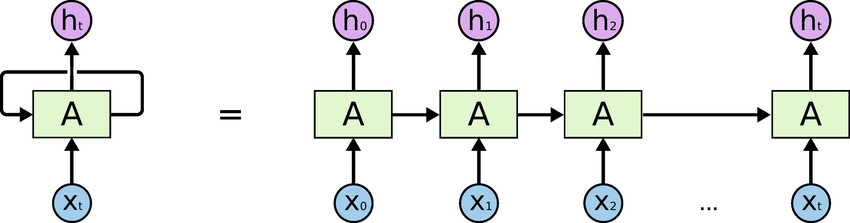

**Let's add a little bit of math.**

Given an input $x$, if we use a Linear Layer and an activation function ($act$), we process $x$ and output an hidden representation as follows:

\\[ Linear(x) = act(x \cdot W+b) \\]

Instead, a simple RNN utilizes two different weights matrices to model both the current memory $m$ and the input $x$. In this way, the output at the timestep $t$ is computed as:

\\[ RNN(x_t) = act(x_t \cdot W_x + b_x + m_{t-1} \cdot W_m + b_m) \\]

As we can see, the concepts behind RNNs are very simple. In this notebook we will not go any deeper about this class of networks and we will leave other related topics to the next clasees. If you want to know more about other types RNNs and more in general to this class of networks, we suggest you to read this [tutorial](https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn).

### Applying RNNs to the Amazon Reviews Stars Predictor
In order to apply RNNs to our running example we need just three steps.


**Step 1**: As we saw in the previous section, the RNNs output one vector for each timestep (in our case for each word). However, we need a general representation for the whole review. In order to model this requirement, we will utilize the last hidden state ($h_t$). Indeed, $h_t$ is produced taking into consideration the last word but even the memory vector coming from the processing of the whole sequence. This strategy is called "many-to-one" and is often used when classifying entire sequences of elements like in our case.

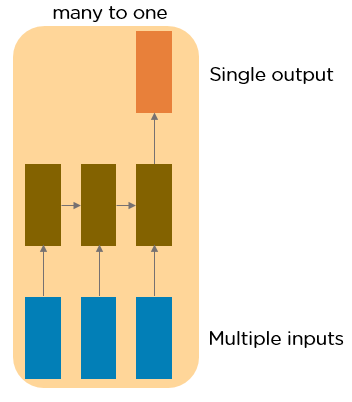


**Step 2**: In order to take advantage of parallel computation, we process input features in batches. Whereas we have worked up until this point with batches of shape $(batch\ size \times features)$, the introduction of RNN-s, which process sequences of elements, change these shapes into $(batch\ size \times sequence\ length \times features)$. 
Now, the problem is that **sequences may not have the same length** (reviews does not contain the same number of words). **To tackle this problem we pad each sequence with a special token, namely the *pad* token** that we will discard in the output. (more on this later)

**Step 3**: We will move the logic to convert words in vectors from our review2vector function to a special layer in PyTorch: torch.nn.Embedding. In this way we will only deal with two-dimension matrices ($batch\ size \times sequence\ length$) and let the **Embedding layer** expand this matrices. In order to do that, we just need to index each word in our vocabulary and store their vector accordingly.

Let's start by indexing each word in our vocabulary. In our case, the words that we have in the vocabulary come from our word embeddings (i.e. the 100k we selected before). Moreover, we initialize even two random vectors to handle the *pad* token and the *unk* token. The last will represent words that are not present in our vocabulary.

In [ ]:
word_index = dict()
vectors_store = []

# pad token, index = 0
vectors_store.append(torch.rand(300))

# unk token, index = 1
vectors_store.append(torch.rand(300))

for word, vector in word_vectors.items():
    word_index[word] = len(vectors_store)
    vectors_store.append(vector)

word_index = defaultdict(lambda: 1, word_index)  # default dict returns 1 (unk token) when unknown word
vectors_store = torch.stack(vectors_store)

In [ ]:
word_index['edoardo']  # let's see if the word_index gives to us the unk index (1)

1

The vectors_store contains all the vectors corresponding to the words in our vocabulary.

In [ ]:
vocabulary_size, hidden_features = vectors_store.shape
print(f"Vocabulary size: {vocabulary_size}")
print(f"Hidden features: {hidden_features}")

Vocabulary size: 100002
Hidden features: 300


As we were saying before, we move the logic to vectorize words from the "review2vector" function to the Embedding layer. Here we define a new function that only takes care of indexing each word in a review.

In [ ]:
def review2indices(review: str) -> torch.Tensor:
    return torch.tensor([word_index[word] for word in review.split(' ')], dtype=torch.long)

Only one thing missing, we need to define our **collate function**. Wait what?!??!

Ok ok, first things first. 

**The collate function is a function that the DataLoader requires in order to batch the elements in our dataset**. Up until now we did not define any collate function because we were using the default one in the DataLoader implementation. Unfortunately, now we need to define our own collate function because we need to pad the sequences in each batch to match the length of the longest sequence in that batch.

**The collate function that we pass to a DataLoader receives in input a list of elements that are of the type returned by the \_\_index\_\_ function of the Dataset class we gave to that very DataLoader**. So in our case we will receive a list of tuples made of the indices of the words contained in a review ($x$) and the number of stars for that review ($y$).

In [ ]:
def rnn_collate_fn(
    data_elements: List[Tuple[torch.Tensor, torch.Tensor]] # list of (x, y) pairs
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    X = [de[0] for de in data_elements]  # list of index tensors

    # to implement the many-to-one strategy
    X_lengths = torch.tensor([x.size(0) for x in X], dtype=torch.long)

    X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0)  #  shape (batch_size x max_seq_len)

    y = [de[1] for de in data_elements]
    y = torch.tensor(y)

    return X, X_lengths, y

We would like you to notice that we store the length of each sequence in a batch in order to retrieve the correct position of the last token in the sequence (our $h_t$). 

We can now declare here our AmazonReviewsRNNDataModule

In [ ]:
class AmazonReviewsRNNDataModule(pl.LightningDataModule):

    def __init__(
        self, 
        data_train_path: str,
        data_dev_path: str,
        data_test_path: str,
        batch_size: int,
        collate_fn=None
    ) -> None:
        super().__init__()
        self.data_train_path = data_train_path
        self.data_dev_path = data_dev_path
        self.data_test_path = data_test_path
        self.batch_size = batch_size
        self.collate_fn = collate_fn

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = AmazonReviewsDataset(self.data_train_path, review2indices)
            self.validation_dataset = AmazonReviewsDataset(self.data_dev_path, review2indices)
        elif stage == 'test':
            self.test_dataset = AmazonReviewsDataset(self.data_test_path, review2indices)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=rnn_collate_fn)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, collate_fn=rnn_collate_fn)

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=rnn_collate_fn)

In [ ]:
amazon_review_rnn_dm = AmazonReviewsRNNDataModule(
    data_train_path='data/dataset.train.tsv',
    data_dev_path='data/dataset.validation.tsv',
    data_test_path='data/dataset.test.tsv',
    batch_size=32,
)

As we can see from the output, the shape of each batch is now ($batch\ size \times sequence\ length$), in contrast to before where it was ($batch\ size \times features$). 

In [ ]:
amazon_review_rnn_dm.setup('test')

for batch in amazon_review_rnn_dm.test_dataloader():
    batch_X, batch_X_lengths, batch_y = batch
    print(batch_X)
    print(batch_X.shape)
    print(batch_y.shape)
    break

tensor([[  501,   501,     0,  ...,     0,     0,     0],
        [11708,    15,    33,  ...,     0,     0,     0],
        [ 2088,    13,    67,  ...,     0,     0,     0],
        ...,
        [  659,   215,   527,  ...,     0,     0,     0],
        [   82,   262,   595,  ...,     0,     0,     0],
        [   23,   623,     1,  ..., 70571, 31304,     1]])
torch.Size([32, 1158])
torch.Size([32])


Here we define our recurrent stars classifier for the Amazon Reviews.

In [ ]:
class AmazonReviewRecurrentClassifier(pl.LightningModule):

    REVIEWS_CLASSES = 5

    def __init__(
        self,
        vectors_store: torch.Tensor,
        n_hidden: int
    ) -> None:
        super().__init__()

        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(vectors_store)

        # recurrent layer
        self.rnn = torch.nn.LSTM(input_size=vectors_store.size(1), hidden_size=n_hidden, num_layers=1, batch_first=True)

        # classification head
        self.lin1 = torch.nn.Linear(n_hidden, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, self.REVIEWS_CLASSES)

        # criterion
        self.loss_fn = torch.nn.CrossEntropyLoss()

        # metrics
        self.val_f1 = pl.metrics.F1(self.REVIEWS_CLASSES)
        self.test_f1 = pl.metrics.F1(self.REVIEWS_CLASSES)

    def forward(
        self, 
        X: torch.Tensor, 
        X_length: torch.Tensor, 
        y: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:

        # embedding words from indices
        embedding_out = self.embedding(X)

        # recurrent encoding
        recurrent_out = self.rnn(embedding_out)[0]
        
        # here we utilize the sequences length to retrieve the last token 
        # output for each sequence
        batch_size, seq_len, hidden_size = recurrent_out.shape

        # we flatten the recurrent output
        # now I have a long sequence of batch x seq_len vectors 
        flattened_out = recurrent_out.reshape(-1, hidden_size)
        
        # and we use a simple trick to compute a tensor of the indices 
        # of the last token in each batch element
        last_word_relative_indices = X_length - 1
        # tensor of the start offsets of each element in the batch
        sequences_offsets = torch.arange(batch_size, device=self.device) * seq_len
        # e.g. (0, 5, 10, 15, ) + ( 3, 2, 1, 4 ) = ( 3, 7, 11, 19 )
        summary_vectors_indices = sequences_offsets + last_word_relative_indices

        # finaly we retrieve the vectors that should summarize every review.
        # (i.e. the last token in the sequence)
        summary_vectors = flattened_out[summary_vectors_indices]

        # now we can classify the reviews with a feedforward pass on the summary
        # vectors
        out = self.lin1(summary_vectors)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)

        # compute logits (which are simply the out variable) and the actual probability distribution (pred, as it is the predicted distribution)
        logits = out
        pred = torch.softmax(logits, dim=-1)

        result = {'logits': logits, 'pred': pred}

        # compute loss
        if y is not None:
            # while mathematically the CrossEntropyLoss takes as input the probability distributions,
            # torch optimizes its computation internally and takes as input the logits instead
            loss = self.loss(logits, y)
            result['loss'] = loss

        return result

    def training_step(
        self, 
        batch: Tuple[torch.Tensor], 
        batch_idx: int
    ) -> torch.Tensor:
        forward_output = self.forward(*batch)
        return forward_output['loss']

    def validation_step(
        self, 
        batch: Tuple[torch.Tensor], 
        batch_idx: int
    ):
        forward_output = self.forward(*batch)
        
        self.val_f1(forward_output['pred'], batch[2])

        self.log('val_f1', self.val_f1, prog_bar=True)
        self.log('val_loss', forward_output['loss'], prog_bar=True)

    def test_step(
        self,
        batch: Tuple[torch.Tensor],
        batch_idx: int
    ):
        forward_output = self.forward(*batch)
        self.val_f1(forward_output['pred'], batch[2])
        self.log('test_f1', self.val_f1, prog_bar=True)

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

Let's break down the different parts of our recurrent classifier:
- **Embedding layer**: the Embedding layer is a useful abstraction that PyTorch provides us which we use to convert words indices in vectors. We initialized it with our vectors_store in order to have a match between the indices we provide to the model and the vectors in the embedding.

- **Recurrent layer**: It is a layer implementing a RNN that we utilize to produce a *summary* representation for each review. It expects as input a batch of shape: ($batch\ size \times sequence\ length \times features$), which is exactly the output of our embdding layer. In this case we opted for a special type of Recurrent Neural Network called LSTM (Long short-term memory) that is especially suited for modeling long sequences of text. You will learn about this special RNN in the upcoming notebooks. 


- **Classification head**: the classification head is a feedforward head on top of the recurrent layer output, and it is exactly the same as before. Indeed, here we would like to stress that the summary vectors that we retrieve utilizing the many-to-one strategy from the encoded sequences is just another way to compute a representation for the review (function $\phi$).

We can now intantiate the classifier and train the network.

In [ ]:
amazon_review_recurrent_classifier = AmazonReviewRecurrentClassifier(vectors_store, n_hidden=128)

In [ ]:
trainer = get_trainer(ckpt_dir="experiments/amazon_reviews_recurrent_classifier")
trainer.fit(model=amazon_review_recurrent_classifier, datamodule=amazon_review_rnn_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory experiments/amazon_reviews_recurrent_classifier exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 30.0 M
1 | rnn       | LSTM             | 220 K 
2 | lin1      | Linear           | 16.5 K
3 | lin2      | Linear           | 645   
4 | loss_fn   | CrossEntropyLoss | 0     
5 | val_f1    | F1               | 0     
6 | test_f1   | F1               | 0     
-----------------------------------------------
237 K     Trainable params
30.0 M    Non-trainable params
30.2 M    Total params
120.952   Total estimated model params size (MB)


Epoch 0, global step 1562: val_f1 reached 0.60492 (best 0.60492), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=0-val_f1=0.6049.ckpt" as top 3


Epoch 1, global step 3125: val_f1 reached 0.62292 (best 0.62292), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=1-val_f1=0.6229.ckpt" as top 3


Epoch 2, global step 4688: val_f1 reached 0.63533 (best 0.63533), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=2-val_f1=0.6353.ckpt" as top 3


Epoch 3, global step 6251: val_f1 reached 0.64173 (best 0.64173), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=3-val_f1=0.6417.ckpt" as top 3


Epoch 4, global step 7814: val_f1 reached 0.64673 (best 0.64673), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=4-val_f1=0.6467.ckpt" as top 3


Epoch 5, global step 9377: val_f1 reached 0.65253 (best 0.65253), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=5-val_f1=0.6525.ckpt" as top 3


Epoch 6, global step 10940: val_f1 reached 0.64873 (best 0.65253), saving model to "/content/experiments/amazon_reviews_recurrent_classifier/epoch=6-val_f1=0.6487.ckpt" as top 3


Epoch 7, step 12503: val_f1 was not in top 3


Epoch 8, step 14066: val_f1 was not in top 3


1

In [ ]:
loaded_model = AmazonReviewRecurrentClassifier.load_from_checkpoint("/content/experiments/amazon_reviews_recurrent_classifier/epoch=5-val_f1=0.6667.ckpt", vectors_store=vectors_store, n_hidden=128)  # REPLACE HERE THE PATH TO A MODEL CHECKPOINT IN THE "experiments/amazon_reviews_classifier" folder
trainer.test(model=loaded_model, datamodule=amazon_review_rnn_dm)

As you can witness, we have significantly improved over the simple "average" function $\phi$.

### Further approaches
- We can utilize a different word embeddings to see if we can improve the performances! We can find a lot (and we mean a lot) of different types of word embeddings [here](http://vectors.nlpl.eu/repository/).
- We can change the recurrent layer and try the other torch.rnn modules that can be find [here](https://pytorch.org/docs/stable/nn.html#recurrent-layers).